In [38]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS  = 3
EPOCH = 10

In [8]:
# Loading data into tensorflow data sets

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
# Gettig the class names, (Will be the name of the folders )
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

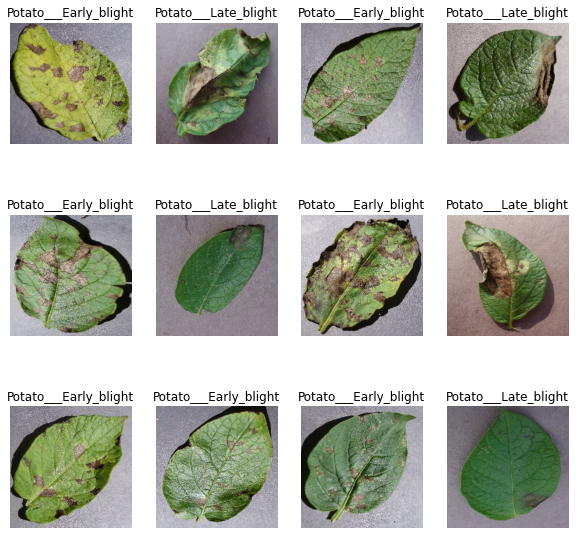

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[ label_batch[i]])

In [11]:
len(dataset)

68

In [12]:
# Function to do train test split as tensorflow dont have a train_test_split function
# ds.take -> takes the first n number of data
# ds.skip -> skips first n number of data

def get_ds_partitions_ts(ds, train_split = 0.8, test_split = 0.1, val_split=0.1, shuffle=True,shuffle_size = 10000):
    ds_size = len(ds)
    if(shuffle):
        ds = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split * ds_size)

    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_ds_partitions_ts(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
# Caching and Prefetching data to improve performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE )
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
# Creating a layer for resizing and rescaling so the model can predic better
# Resizing so that if a image of different size is given it can resize to the IMAGE_SIZE
# Rescalling the image from 0- 255 (RGB)  to values from 0-1 

resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
# data agumentaion is used to make the model to learn a data in different senerios ,
# ie , if the image is rotated or have high contracst or so

data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        layers.experimental.preprocessing.RandomRotation(0.2)
    ])

### Pre-processing is done and now ready to build model using Convuluted Neural Network

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # Convolution layer
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    #pooling 
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),  activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [22]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [23]:
history = model.fit(
    train_ds, 
    epochs = EPOCH, 
    batch_size = BATCH_SIZE, 
    verbose = 1, 
    validation_data=val_ds
    )

Epoch 1/10
54/54 [==============================] - 76s 1s/step - loss: 0.8458 - accuracy: 0.5556 - val_loss: 0.8133 - val_accuracy: 0.6979
Epoch 2/10
54/54 [==============================] - 71s 1s/step - loss: 0.4563 - accuracy: 0.8322 - val_loss: 0.3366 - val_accuracy: 0.8594
Epoch 3/10
54/54 [==============================] - 66s 1s/step - loss: 0.3041 - accuracy: 0.8756 - val_loss: 0.2070 - val_accuracy: 0.9219
Epoch 4/10
54/54 [==============================] - 74s 1s/step - loss: 0.2265 - accuracy: 0.9062 - val_loss: 0.3779 - val_accuracy: 0.8542
Epoch 5/10
54/54 [==============================] - 77s 1s/step - loss: 0.2153 - accuracy: 0.9196 - val_loss: 0.4363 - val_accuracy: 0.8281
Epoch 6/10
54/54 [==============================] - 75s 1s/step - loss: 0.2018 - accuracy: 0.9184 - val_loss: 0.1378 - val_accuracy: 0.9583
Epoch 7/10
54/54 [==============================] - 66s 1s/step - loss: 0.1763 - accuracy: 0.9277 - val_loss: 0.1270 - val_accuracy: 0.9688
Epoch 8/10
54/54 [==

In [24]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 319ms/step - loss: 0.2505 - accuracy: 0.8867


In [26]:
scores

[0.2504573464393616, 0.88671875]

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

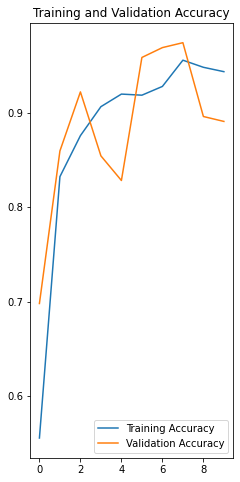

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH), acc, label= 'Training Accuracy')
plt.plot(range(EPOCH), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

First image to predict
actual label Potato___Early_blight
1/1 [==============================] - 0s 382ms/step
Potato___Early_blight


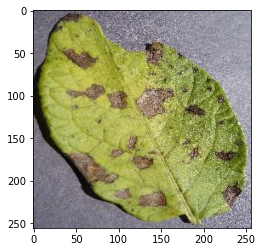

In [41]:
for images_batch , labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print("actual label", class_names[first_label])

    batch_prediction = model.predict(image_batch)

    print(class_names[np.argmax(batch_prediction[0])])
